<a href="https://colab.research.google.com/github/ravichas/bifx-546/blob/main/Notebooks/Chapter1_Healthcare_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 1 – What Is Data Science?**
Companion notebook for lecture and slides (DataSciencester + Healthcare examples).

**Learning goals**
- Practice working with a simple social network in Python
- Compute basic network metrics (number of friends, average connections)
- Build a simple “friends of friends” recommender
- Explore a tiny **healthcare** example using grouping and aggregation
- Do a basic **text frequency** analysis similar to interests/topics


## Part 1 – The DataSciencester Network

We start from the book’s toy example: a social network of data scientists.


In [ ]:
# Users: each has an id and a name
users = [
    { "id": 0, "name": "Hero" },
    { "id": 1, "name": "Dunn" },
    { "id": 2, "name": "Sue" },
    { "id": 3, "name": "Chi" },
    { "id": 4, "name": "Thor" },
    { "id": 5, "name": "Clive" },
    { "id": 6, "name": "Hicks" },
    { "id": 7, "name": "Devin" },
    { "id": 8, "name": "Kate" },
    { "id": 9, "name": "Klein" },
]

# Friendship pairs: each tuple connects two user ids
friendship_pairs = [
    (0, 1), (0, 2),
    (1, 2), (1, 3),
    (2, 3),
    (3, 4),
    (4, 5),
    (5, 6), (5, 7),
    (6, 8),
    (7, 8),
    (8, 9),
]

# Build a dict: user_id -> list of friend_ids
friendships = {user["id"]: [] for user in users}

for i, j in friendship_pairs:
    friendships[i].append(j)
    friendships[j].append(i)

friendships


{0: [1, 2],
 1: [0, 2, 3],
 2: [0, 1, 3],
 3: [1, 2, 4],
 4: [3, 5],
 5: [4, 6, 7],
 6: [5, 8],
 7: [5, 8],
 8: [6, 7, 9],
 9: [8]}

### Number of friends and average connections

In [ ]:
def number_of_friends(user):
    """How many friends does _user_ have?"""
    user_id = user["id"]
    friend_ids = friendships[user_id]
    return len(friend_ids)

# Total connections in the network
total_connections = sum(number_of_friends(user) for user in users)
num_users = len(users)
avg_connections = total_connections / num_users

print("Total connections:", total_connections)
print("Number of users:", num_users)
print("Average connections:", avg_connections)


Total connections: 24
Number of users: 10
Average connections: 2.4


### Visualizing number of friends (degree)

We can visualize how many friends each user has.


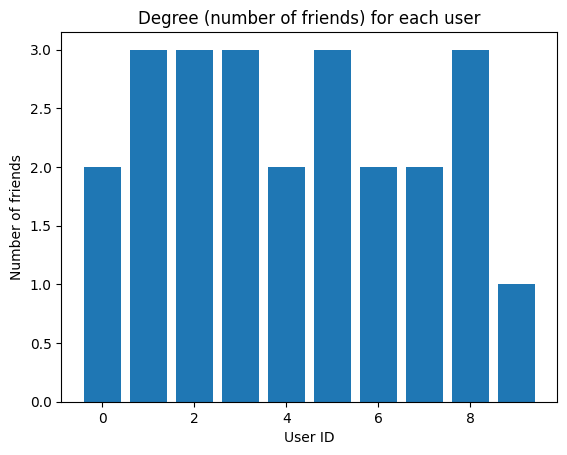

[(1, 3),
 (2, 3),
 (3, 3),
 (5, 3),
 (8, 3),
 (0, 2),
 (4, 2),
 (6, 2),
 (7, 2),
 (9, 1)]

In [ ]:
import matplotlib.pyplot as plt

num_friends_by_id = [(user["id"], number_of_friends(user)) for user in users]
num_friends_by_id.sort(key=lambda x: x[1], reverse=True)

ids = [user_id for user_id, _ in num_friends_by_id]
degrees = [deg for _, deg in num_friends_by_id]

plt.bar(ids, degrees)
plt.xlabel("User ID")
plt.ylabel("Number of friends")
plt.title("Degree (number of friends) for each user")
plt.show()

num_friends_by_id


## Part 2 – Friends of Friends and Interests

We now build a simple recommender: “Data Scientists You May Know”.


In [ ]:
from collections import Counter, defaultdict

def friends_of_friends(user):
    user_id = user["id"]
    # Count how often each friend-of-a-friend appears
    return Counter(
        foaf_id
        for friend_id in friendships[user_id]
        for foaf_id in friendships[friend_id]
        if foaf_id != user_id
        and foaf_id not in friendships[user_id]
    )

print("Friends-of-friends suggestions for Chi (id=3):")
print(friends_of_friends(users[3]))


Friends-of-friends suggestions for Chi (id=3):
Counter({0: 2, 5: 1})


### Adding interests

We reuse the book’s small **interests** dataset and build indices for fast lookup.


In [ ]:
interests = [
    (0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
    (0, "Spark"), (0, "Storm"), (0, "Cassandra"),
    (1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
    (1, "Postgres"),
    (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
    (2, "numpy"), (2, "statsmodels"), (2, "pandas"),
    (3, "R"), (3, "Python"), (3, "statistics"),
    (3, "regression"), (3, "probability"),
    (4, "machine learning"), (4, "regression"),
    (4, "decision trees"), (4, "libsvm"),
    (5, "Python"), (5, "R"), (5, "Java"),
    (5, "C++"), (5, "Haskell"), (5, "programming languages"),
    (6, "statistics"), (6, "probability"),
    (6, "mathematics"), (6, "theory"),
    (7, "machine learning"), (7, "scikit-learn"),
    (7, "Mahout"), (7, "neural networks"),
    (8, "neural networks"), (8, "deep learning"),
    (8, "Big Data"), (8, "artificial intelligence"),
    (9, "Hadoop"), (9, "Java"),
    (9, "MapReduce"), (9, "Big Data"),
]

user_ids_by_interest = defaultdict(list)
interests_by_user_id = defaultdict(list)

for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id)
    interests_by_user_id[user_id].append(interest)

def most_common_interests_with(user):
    user_id = user["id"]
    return Counter(
        other_user_id
        for interest in interests_by_user_id[user_id]
        for other_user_id in user_ids_by_interest[interest]
        if other_user_id != user_id
    )

print("Users who share interests with Hero (id=0):")
most_common_interests_with(users[0])


Users who share interests with Hero (id=0):


Counter({9: 3, 8: 1, 1: 2, 5: 1})

## Part 3 – Healthcare Example: Readmission Risk (Toy Data)

Now let’s switch domains and look at a **tiny** synthetic healthcare example.

Imagine we have a small cohort of hospitalized patients with:
- `age` (in years)
- `num_chronic_conditions` (count of chronic diseases)
- `readmitted_30d` (1 = readmitted within 30 days, 0 = not readmitted)

We want to see how **readmission rate** changes across simple buckets.


In [ ]:
patients = [
    # patient_id, age, num_chronic_conditions, readmitted_30d
    (1, 45, 1, 0),
    (2, 52, 2, 0),
    (3, 67, 3, 1),
    (4, 73, 4, 1),
    (5, 36, 0, 0),
    (6, 59, 2, 1),
    (7, 81, 4, 1),
    (8, 69, 3, 0),
    (9, 50, 1, 0),
    (10, 77, 5, 1),
]

def age_bucket(age):
    if age < 50:
        return "<50"
    elif age < 70:
        return "50–69"
    else:
        return "70+"

from collections import defaultdict

# Group readmission flags by age bucket
readmissions_by_bucket = defaultdict(list)

for patient_id, age, num_cc, readmitted in patients:
    bucket = age_bucket(age)
    readmissions_by_bucket[bucket].append(readmitted)

# Compute readmission rate per bucket
readmission_rate_by_bucket = {
    bucket: sum(flags) / len(flags)
    for bucket, flags in readmissions_by_bucket.items()
}

readmission_rate_by_bucket


{'<50': 0.0, '50–69': 0.4, '70+': 1.0}

We can also look at readmission rate by **number of chronic conditions**.


In [ ]:
def cc_bucket(num_cc):
    if num_cc == 0:
        return "0"
    elif num_cc <= 2:
        return "1–2"
    elif num_cc <= 4:
        return "3–4"
    else:
        return "5+"

readmissions_by_cc_bucket = defaultdict(list)

for patient_id, age, num_cc, readmitted in patients:
    bucket = cc_bucket(num_cc)
    readmissions_by_cc_bucket[bucket].append(readmitted)

readmission_rate_by_cc_bucket = {
    bucket: sum(flags) / len(flags)
    for bucket, flags in readmissions_by_cc_bucket.items()
}

readmission_rate_by_cc_bucket


{'1–2': 0.25, '3–4': 0.75, '0': 0.0, '5+': 1.0}

Even with this tiny dataset, we see the **idea** from Chapter 1:

> Bucket a continuous variable (tenure, age, conditions) and compare averages across buckets.

In real healthcare data, these buckets would be chosen more carefully and evaluated more rigorously.


## Part 4 – Healthcare Text Example: Common Terms in Notes

We now mirror the "topics of interest" idea with a **toy set of clinical note snippets**.


In [ ]:
clinical_notes = [
    (1, "Patient has diabetes and hypertension, started on insulin."),
    (2, "History of heart failure and chronic kidney disease."),
    (3, "Hypertension controlled with medication, check kidney function."),
    (4, "Diabetes follow-up visit, discuss diet and exercise plan."),
    (5, "Shortness of breath, possible heart failure exacerbation."),
]

from collections import Counter
import re

def tokenize(text):
    # Very simple tokenizer: lowercase + split on non-letters
    return [w for w in re.split(r"[^a-zA-Z]+", text.lower()) if w]

word_counts = Counter(
    word
    for note_id, text in clinical_notes
    for word in tokenize(text)
)

# Show the most common words (excluding very common stopwords for readability)
stopwords = {"and", "of", "on", "the", "has", "with", "a", "an", "in", "to"}
common_terms = [(w, c) for w, c in word_counts.most_common() if w not in stopwords]

common_terms[:15]


[('diabetes', 2),
 ('hypertension', 2),
 ('heart', 2),
 ('failure', 2),
 ('kidney', 2),
 ('patient', 1),
 ('started', 1),
 ('insulin', 1),
 ('history', 1),
 ('chronic', 1),
 ('disease', 1),
 ('controlled', 1),
 ('medication', 1),
 ('check', 1),
 ('function', 1)]

This is analogous to counting words in **interests**:

- We normalize the text (lowercase)
- Split into tokens
- Count frequencies with `Counter`

In real applications, we would use better tokenization, stopword lists, and domain-specific vocabularies (e.g., SNOMED, ICD-10).

## Wrap-Up

In this notebook we:

- Recreated the **DataSciencester** network and computed simple graph metrics
- Built a small **friends-of-friends** and **shared interests** recommender
- Explored a **healthcare readmission** example using buckets and averages
- Counted **common words** in tiny clinical note snippets

These are small building blocks for much more powerful data science workflows in both tech and healthcare.
